# TF-IDF Vectorization

TFIDF, short for __term frequency–inverse document frequency__, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TFIDF scores are calculated for each song to be used as features for modelling later.

In [5]:
#import libraries
import pandas as pd
import numpy as np
import collections
import re
import sys
import time
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import wordninja
from itertools import islice
import pickle
from sklearn.model_selection import train_test_split

In [6]:
df=pd.read_pickle("df_add_feat") # reload df from pickle

In [7]:
df.columns

Index(['Rank', 'Song', 'Artist', 'Year', 'Lyrics', 'Source', 'Artists clean',
       'artist_song1', 'songs_clean', 'artist_song2', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'error',
       'lyrics_clean', 'tokens', 'polysyl_count', 'difficult_count',
       'count_rhyming_words', 'rank_bins'],
      dtype='object')

## 1. TFIDF-Vectorization

In [8]:
#apply tfidf vectorizer after count vecotizer with n_gram_range==1

In [9]:
#count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

def dummy(tokens):
    return tokens

cv = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 1)
    )  
tokens=df.tokens
x = cv.fit_transform(tokens)
words = cv.get_feature_names()
len(words)

16118

In [10]:
#tfidf vectorizer 
vectorizer = TfidfVectorizer(tokenizer=dummy,
        preprocessor=dummy,
        ngram_range=(1, 1))

X_tfidf = vectorizer.fit(tokens.values) 

idf_scores = X_tfidf.idf_

C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [11]:
#make histogram of idf scores
maxi=np.max(idf_scores)
mean=np.mean(idf_scores)
min=np.min(idf_scores)
print(maxi, mean, min)
len(idf_scores)

8.789868559054707 7.843214233681948 1.4558656327818755


16118

<AxesSubplot:ylabel='Count'>

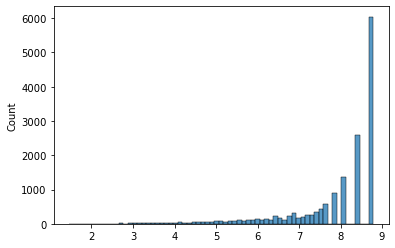

In [12]:
import seaborn as sns
sns.histplot(data=idf_scores)

In [13]:
X_tfidf.get_feature_names()[:10]

['aaa',
 'aaaa',
 'aaaaaa',
 'aaliyah',
 'aami',
 'aap',
 'ab',
 'aba',
 'abaca',
 'abandon']

In [14]:
#filter out ngrams that occur in too few or too many songs

filtered_indices = np.argwhere(((idf_scores>6) ))
filtered_indices = [idx[0] for idx in filtered_indices]

#list of vocabulary from the vectorizer
vocabulary = X_tfidf.get_feature_names()

#preparing a list with filtered vocabulary
filtered_voc = [vocabulary[i] for i in filtered_indices]

#size before and after filtering
print("no of words before filtering: ", len(idf_scores))
print("no of words after filtering: ", len(filtered_indices))

no of words before filtering:  16118
no of words after filtering:  14596


In [15]:
filtered_voc[:10]

['aaa',
 'aaaa',
 'aaaaaa',
 'aaliyah',
 'aami',
 'aap',
 'ab',
 'aba',
 'abaca',
 'abandon']

In [16]:
#keep only filtered indices
X_tfidf=vectorizer.fit_transform(tokens.values)[:,filtered_indices]
type(X_tfidf)
print(X_tfidf.shape)

(4831, 14596)


## 2. Tf-idf feature selection using tuned random forests

Of the over 14,000 scores, I select the 1,000 most important ones using random forests.

In [17]:
#random forest model
#define parameter grid for randomized search with forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#n_estimators
n_estimators = [250,300, 350]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_estimators':n_estimators}


In [18]:
def rf_rs(X_train, X_test, y_train, y_test):

    #Instantiate the classifier
    rf=RandomForestClassifier(n_jobs=-1)
    rs=RandomizedSearchCV(rf,random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
    rs.fit(X_train, y_train)
    return rs

In [19]:
# fit tuned model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def fit_tuned_rf_model(model):
    print("tuned hyperparameters :(best parameters) ", model.best_params_)
    print("ROC AUC :", model.best_score_)

    modelCV=RandomForestClassifier(max_features=model.best_params_['max_features'], max_depth=model.best_params_['max_depth'], min_samples_split=model.best_params_['min_samples_split'], min_samples_leaf=model.best_params_['min_samples_leaf'], bootstrap=model.best_params_['bootstrap'],n_estimators=model.best_params_['n_estimators'])
    modelCV.fit(X_train, y_train)

    #return predicted probabilities
    probs = modelCV.predict_proba(X_test)
        # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    roc_auc=roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    print("Fitted tuned random forest model ", roc_auc)
    return modelCV, roc_auc, fpr, tpr

In [20]:
#save labels: ranking<50=1, 0 otherwise
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])
df['y']=y
df[['y','Rank']].groupby('y').mean()
len(y)
df.Rank.groupby(y).mean()

Rank
1    25.435178
0    75.410959
Name: Rank, dtype: float64

In [21]:
#Random forest classifier on tfidf features
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.33, random_state=42)
rf=rf_rs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.0min finished


In [22]:
# save the tuned model to disk
filename = 'tuned_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [23]:
#fit tuned model
rf_fit=fit_tuned_rf_model(rf)

tuned hyperparameters :(best parameters)  {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
ROC AUC : 0.5088986402261199
Fitted tuned random forest model  0.5270824094081532


In [24]:
#plot most important features
importance=rf_fit[0].feature_importances_
feat_dict=dict(zip(filtered_voc,importance))
sort={k: v for k, v in sorted(feat_dict.items(), reverse=True, key=lambda item: item[1])}
n_items=list(islice(sort.items(), 50))


In [25]:
coeffs=[round(i[1],5) for i in n_items]
indices=[i[0] for i in n_items]


<BarContainer object of 50 artists>

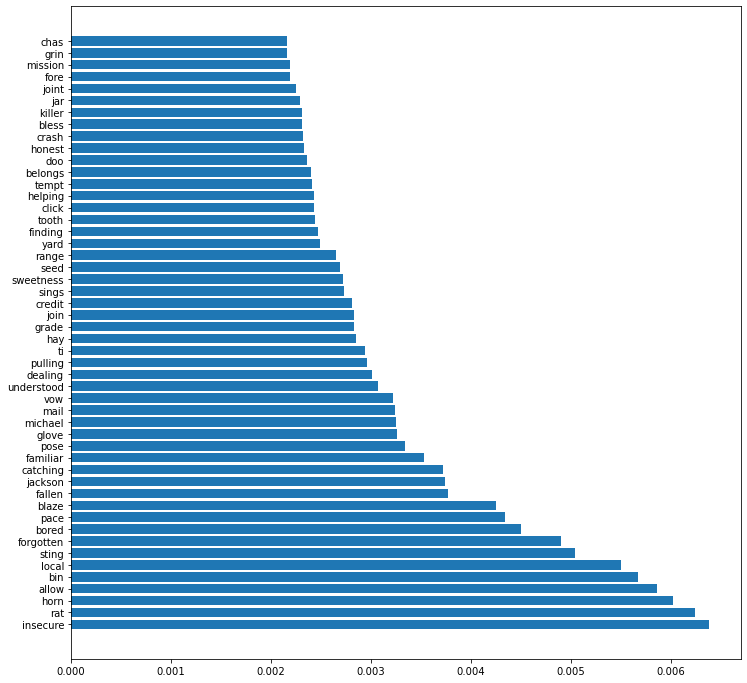

In [26]:
plt.figure(figsize=(12,12))
plt.barh(indices, coeffs)

In [27]:
#Select top 1000 features
top_1000=list(sort.items())[:1000]
top_1000_feat=[i[0] for i in top_1000]
#select top feat from X_tfidf
#get indices of top1000 features from filtered_voc
top_1000_indices = [i for i, value in enumerate(filtered_voc) if value in top_1000_feat]
X_1000=X_tfidf[:,top_1000_indices]
X_1000.shape

(4831, 1000)

In [35]:
pd.DataFrame.sparse.from_spmatrix(X_1000).to_pickle("df_tfidf") # save with pickle